# BASICS 02 - HOTS in PyTorch

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd ../hots
import tonic, torch, os, pickle
from tqdm import tqdm
from network import network
from layer import mlrlayer
from timesurface import timesurface
from utils import get_loader, make_histogram_classification, HOTS_Dataset

print(f'Tonic version installed -> {tonic.__version__}')

print(f'Number of GPU devices available: {torch.cuda.device_count()}')
for N_gpu in range(torch.cuda.device_count()):
    print(f'GPU {N_gpu+1} named {torch.cuda.get_device_name(N_gpu)}')

/home/antoine/homhots/hotsline/hots
Tonic version installed -> 1.0.15
Number of GPU devices available: 1
GPU 1 named GeForce RTX 2080 Ti


## Loading of the dataset for the clustering phase

In [3]:
transform = tonic.transforms.NumpyAsType(int)
trainset = tonic.datasets.POKERDVS(save_to='../../Data/', train=True, transform=transform)
testset = tonic.datasets.POKERDVS(save_to='../../Data/', train=False, transform=transform)
loader = get_loader(trainset)
num_sample_train = len(loader)
num_sample_test = len(testset)
print(f'number of samples in the training set: {len(loader)}')

number of samples in the training set: 48


## Initialization of the network

In [4]:
name = 'homeohots'
homeo = True
timestr = '2022-04-22'
dataset_name = 'poker'

Rz = [2, 4]
N_neuronz = [8, 16]
tauz = [1e3, 4e3]

hots = network(name, dataset_name, timestr, trainset.sensor_size, nb_neurons = N_neuronz, tau = tauz, R = Rz, homeo = homeo)

## Unsupervised clustering

In [5]:
if not os.path.exists('../Records/'):
    os.mkdir('../Records/')
    os.mkdir('../Records/networks/')
filtering_threshold = [2*Rz[L] for L in range(len(Rz))]
path = '../Records/networks/'+hots.name+'.pkl'
if not os.path.exists(path):
    hots.clustering(loader, trainset.ordering, filtering_threshold, record = True)

## Training of the classification layer

In [12]:
jitter = (None, None)

train_path = f'../Records/output/train/{hots.name}_{num_sample_train}_{jitter}/'
test_path = f'../Records/output/test/{hots.name}_{num_sample_test}_{jitter}/'

transform = tonic.transforms.NumpyAsType(int)
testset_output = HOTS_Dataset(test_path, trainset.sensor_size, dtype=trainset.dtype, transform=transform)
trainset_output = HOTS_Dataset(train_path, trainset.sensor_size, dtype=trainset.dtype, transform=transform)

In [7]:
def fit_mlr(loader, 
            model_path,
            tau_cla,
            learning_rate,
            betas,
            num_epochs,
            ts_size,
            ordering,
            n_classes,
            num_workers=0):
    
    if os.path.exists(model_path):
        with open(model_path, 'rb') as file:
            classif_layer, losses = pickle.load(file)
    
    else:
        torch.set_default_tensor_type("torch.DoubleTensor")
        criterion = torch.nn.BCELoss(reduction="mean")
        amsgrad = True #or False gives similar results
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        N = ts_size[0]*ts_size[1]*ts_size[2]

        classif_layer = mlrlayer(N, n_classes, device=device)
        classif_layer.train()
        optimizer = torch.optim.Adam(
            classif_layer.parameters(), lr=learning_rate, betas=betas, amsgrad=amsgrad
        )

        for epoch in tqdm(range(int(num_epochs))):
            losses = []
            for events, label in loader:
                X, ind_filtered = timesurface(events.squeeze(0).squeeze(0), (ts_size[0], ts_size[1], ts_size[2]), ordering, tau = tau_cla, device=device)
                
                X, label = X.to(device) ,label.to(device)
                X = X.reshape(X.shape[0], N)

                outputs = classif_layer(X)

                n_events = X.shape[0]
                labels = label*torch.ones(n_events).type(torch.LongTensor).to(device)
                labels = torch.nn.functional.one_hot(labels, num_classes=n_classes).type(torch.DoubleTensor).to(device)

                loss = criterion(outputs, labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                losses.append(loss.item())

        with open(model_path, 'wb') as file:
            pickle.dump([classif_layer, losses], file, pickle.HIGHEST_PROTOCOL)

    return classif_layer, losses

In [8]:
def predict_mlr(mlrlayer,
                tau_cla,
                loader,
                results_path,
                timesurface_size,
                ordering,
                num_workers = 0,
        ):    
    
    if os.path.isfile(results_path):
        with open(results_path, 'rb') as file:
            likelihood, true_target, timestamps = pickle.load(file) 
    else:    
        
        N = timesurface_size[0]*timesurface_size[1]*timesurface_size[2]
        t_index = ordering.index('t')

        with torch.no_grad():
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            logistic_model = mlrlayer.to(device)
            likelihood, true_target, timestamps = [], [], []

            for events, label in tqdm(loader):
                timestamps.append(events[0,:,t_index])
                X, ind_filtered = timesurface(events.squeeze(0).squeeze(0), (ts_size[0], ts_size[1], ts_size[2]), ordering, tau = tau_cla, device=device)
                X, label = X.to(device) ,label.to(device)
                X = X.reshape(X.shape[0], N)
                n_events = X.shape[0]
                outputs = logistic_model(X)
                likelihood.append(outputs.cpu().numpy())
                true_target.append(label.cpu().numpy())

            with open(results_path, 'wb') as file:
                pickle.dump([likelihood, true_target, timestamps], file, pickle.HIGHEST_PROTOCOL)

    return likelihood, true_target, timestamps

In [9]:
tau_cla = 1e4

In [ ]:
trainloader = get_loader(trainset_output)
testloader = get_loader(testset_output)
num_workers = 0
learning_rate = 0.005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 5 + 1
N_output_neurons = N_neuronz[-1]
ts_size = (trainset.sensor_size[0],trainset.sensor_size[1],N_output_neurons)
t_index = testset_output.ordering.index('t')

results = []
for tau_cla in [1e3, 2e3, 5e3, 1e4, 2e4, 3e4]:
    model_path = f'test_new_{tau_cla}.pkl'
    results_path = f'test_results_new_{tau_cla}.pkl'
    classif_layer, losses = fit_mlr(trainloader, model_path, tau_cla, learning_rate, betas, num_epochs, ts_size, trainset.ordering, len(trainset.classes))
    likelihood, true_target, timestamps = predict_mlr(classif_layer,tau_cla,loader,results_path,ts_size,testset_output.ordering)
    meanac, onlinac, lastac, _, _ = score_classif_events(likelihood, true_target)
    results.append([meanac,lastac, onlinac])

Mean accuracy: 97.6%
Mean accuracy: 98.3%
Mean accuracy: 98.1%
Mean accuracy: 97.7%
Mean accuracy: 98.5%


  3%|████▍                                                                                                                                            | 1/33 [00:30<16:01, 30.06s/it]

In [ ]:
loader = get_loader(trainset_output)
model_path = f'test_new_{tau_cla}.pkl'

num_workers = 0
learning_rate = 0.005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 5 + 1
N_output_neurons = N_neuronz[-1]
ts_size = (trainset.sensor_size[0],trainset.sensor_size[1],N_output_neurons)

classif_layer, losses = fit_mlr(loader, model_path, tau_cla, learning_rate, betas, num_epochs, ts_size, trainset.ordering, len(trainset.classes))
likelihood, true_target, timestamps = predict_mlr(classif_layer,tau_cla,loader,results_path,ts_size,testset_output.ordering)

In [ ]:
loader = get_loader(testset_output)
results_path = f'test_results_new_{tau_cla}.pkl'
t_index = testset_output.ordering.index('t')

likelihood, true_target, timestamps = predict_mlr(classif_layer,tau_cla,loader,results_path,ts_size,testset_output.ordering)

In [ ]:
score_classif_events(likelihood, true_target)

In [14]:
import numpy as np
def score_classif_events(likelihood, true_target, thres=None, verbose=True):
    
    max_len = 0
    for likeli in likelihood:
        if max_len<likeli.shape[0]:
            max_len=likeli.shape[0]

    matscor = np.zeros([len(true_target),max_len])
    matscor[:] = np.nan
    sample = 0
    lastac = 0
    nb_test = len(true_target)

    for likelihood_, true_target_ in zip(likelihood, true_target):
        pred_target = np.zeros(len(likelihood_))
        pred_target[:] = np.nan
        if not thres:
            pred_target = np.argmax(likelihood_, axis = 1)
        else:
            for i in range(len(likelihood_)):
                if np.max(likelihood_[i])>thres:
                    pred_target[i] = np.argmax(likelihood_[i])
        for event in range(len(pred_target)):
            if np.isnan(pred_target[event])==False:
                matscor[sample,event] = pred_target[event]==true_target_
        if pred_target[-1]==true_target_:
            lastac+=1
        sample+=1

    meanac = np.nanmean(matscor)
    onlinac = np.nanmean(matscor, axis=0)
    lastac/=nb_test
    truepos = len(np.where(matscor==1)[0])
    falsepos = len(np.where(matscor==0)[0])

    if verbose:
        print(f'Mean accuracy: {np.round(meanac,3)*100}%')
        plt.semilogx(onlinac, '.');
        plt.xlabel('number of events');
        plt.ylabel('online accuracy');
        plt.title('LR classification results evolution as a function of the number of events');
    
    return meanac, onlinac, lastac, truepos, falsepos

def score_classif_time(likelihood, true_target, timestamps, timestep, thres=None, verbose=True):
    
    max_dur = 0
    for time in timestamps:
        if max_dur<time[-1]:
            max_dur=time[-1]
            
    time_axis = np.arange(0,max_dur,timestep)

    matscor = np.zeros([len(true_target),len(time_axis)])
    matscor[:] = np.nan
    sample = 0
    lastac = 0
    nb_test = len(true_target)
    
    if verbose: pbar = tqdm(total=len(likelihood))
    
    for likelihood_, true_target_, timestamps_ in zip(likelihood, true_target, timestamps):
        pred_timestep = np.zeros(len(time_axis))
        pred_timestep[:] = np.nan
        for step in range(1,len(pred_timestep)):
            indices = np.where((timestamps_.numpy()<=time_axis[step])&(timestamps_.numpy()>time_axis[step-1]))[0]
            mean_likelihood = np.mean(likelihood_[indices,:],axis=0)
            if np.isnan(mean_likelihood).sum()>0:
                pred_timestep[step] = np.nan
            else:
                if not thres:
                    pred_timestep[step] = np.nanargmax(mean_likelihood)
                elif np.max(likelihood_[indices,np.nanargmax(mean_likelihood)])>thres:
                    pred_timestep[step] = np.nanargmax(mean_likelihood)
                else:
                    pred_timestep[step] = np.nan
            if not np.isnan(pred_timestep[step]):
                matscor[sample,step] = pred_timestep[step]==true_target_
        
        lastev = -1
        while np.isnan(pred_timestep[lastev]):
            lastev -= 1
        if pred_timestep[lastev]==true_target_:
            lastac+=1
        if verbose: pbar.update(1)
        sample+=1
       
    if verbose: pbar.close()
    
    meanac = np.nanmean(matscor)
    onlinac = np.nanmean(matscor, axis=0)
    lastac/=nb_test
    truepos = len(np.where(matscor==1)[0])
    falsepos = len(np.where(matscor==0)[0])
        
    if verbose:
        print(f'Mean accuracy: {np.round(meanac,3)*100}%')
        plt.semilogx(time_axis*1e-3,onlinac, '.');
        plt.xlabel('time (in ms)');
        plt.ylabel('online accuracy');
        plt.title('LR classification results evolution as a function of time');
    
    return meanac, onlinac, lastac, truepos, falsepos

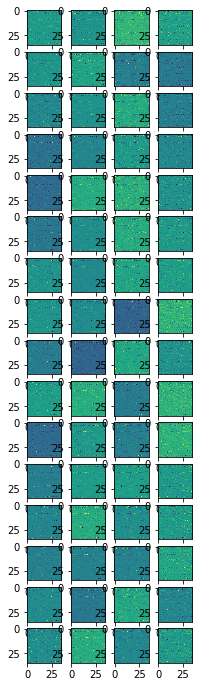

In [16]:
import matplotlib.pyplot as plt
kernels = classif_layer.linear.weight.data.cpu().numpy()
fig, ax = plt.subplots(N_output_neurons, kernels.shape[0], figsize=(3, 12))
for n in range(kernels.shape[0]):
    kernel = kernels[n].reshape(trainset.sensor_size[0],trainset.sensor_size[1], N_output_neurons)
    for p in range(N_output_neurons):
        ax[p, n].imshow(kernel[:,:,p])